In [1]:
# DO NOT MODIFY THIS PART

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# DO NOT MODIFY THIS PART

X = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32)
Y = torch.tensor([[0], [1], [1], [0]], dtype=torch.float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


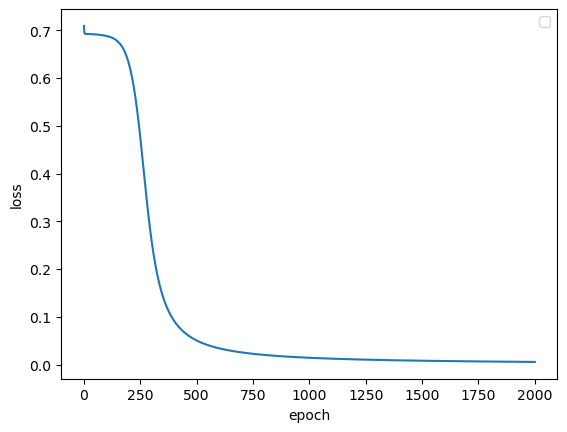

In [3]:
# DO NOT MODIFY THIS PART

model = nn.Sequential(nn.Linear(2, 2, bias=True), nn.Sigmoid(),
                      nn.Linear(2, 1, bias=True), nn.Sigmoid())

criterion = torch.nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1) 
losses = []

for step in range(2001): 
    optimizer.zero_grad()
    hypothesis = model(X)
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()        
    losses.append(cost.item())

plt.plot(losses)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [4]:
# DO NOT MODIFY THIS PART

Y_hat = model(X)
print('Predicted: ', Y_hat)
print('Actual: ', Y)

Predicted:  tensor([[0.0055],
        [0.9925],
        [0.9949],
        [0.0047]], grad_fn=<SigmoidBackward0>)
Actual:  tensor([[0.],
        [1.],
        [1.],
        [0.]])


*** Write down your answer here ***

Formula of bias for layer 2

$$\frac{\partial L}{\partial b^2} = (\hat{y_i}-y_i)$$

Formula of weights of layer 2
$$\frac{\partial L}{\partial \vec{w}^{\,(2)}} = \begin{bmatrix}
\frac{\partial L}{\partial w^2_{11}}\\
\frac{\partial L}{\partial w^2_{21}}
\end{bmatrix} =
\begin{bmatrix}
(\hat{y_i}-y_i)h^1_1 \\
(\hat{y_i}-y_i)h^1_2
\end{bmatrix}
$$

Formula of biases of layer 1
$$\frac{\partial L}{\partial \vec{b}^{\,(1)}} =\begin{bmatrix}
\frac{\partial L}{\partial b^1_1}\\
\frac{\partial L}{\partial b^1_2}
\end{bmatrix} = 
\begin{bmatrix}
(\hat{y_i}-y_i)w^2_{11}h^1_1(1-h^1_1) \\
(\hat{y_i}-y_i)w^2_{21}h^1_2(1-h^1_2)
\end{bmatrix}
$$

Formula of weights of layer 1
$$
\frac{\partial L}{\partial \vec{W}^{\,(1)}} =\begin{bmatrix}
\frac{\partial L}{\partial w^1_{11}} & \frac{\partial L}{\partial w^1_{12}} \\
\frac{\partial L}{\partial w^1_{21}} & \frac{\partial L}{\partial w^1_{22}}  
\end{bmatrix} = 
\begin{bmatrix}
(\hat{y_i}-y_i) w^2_{11}h^1_1(1-h^1_1)x_1 & 
(\hat{y_i}-y_i) w^2_{21}h^1_2(1-h^1_2)x_1 \\
(\hat{y_i}-y_i) w^2_{11}h^1_1(1-h^1_1)x_2 &
(\hat{y_i}-y_i) w^2_{21}h^1_2(1-h^1_2)x_2
\end{bmatrix}
$$

# Implementing my Neural Network From Scratch

In [5]:
import numpy as np
import matplotlib.pyplot as plt

Loss Function: Binary Cross-Entropy 
$$-\frac{1}{N}\sum_i^N (y_i*log(\hat{y_i}))+(1-y_i)*(log(1-\hat{y_i}))$$

Derivative of Binary Cross-Entropy (**For a single data point**): 
$$ 
\frac{\partial L}{\partial \hat{y_i}}=-\frac{1}{N}*\frac{y_i-\hat{y}_i}{\hat{y_i}(1-\hat{y_i})}
$$

In [6]:
# Helper math functions

def binaryCrossEntropyLoss(y_pred, y_exp):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15) # Preventing any logs by 0
    return -np.mean(y_exp * np.log(y_pred) + (1 - y_exp) * (np.log(1-y_pred)))

def derivativeBinaryCrossEntropyLoss(y_pred, y_exp):
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    return (-1) * ((y_exp - y_pred) / (y_pred * (1-y_pred)))

def sigmoid(z):
        return 1 / (1 + np.exp(-z))
    
def derivativeSigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

**Neural Network class implemented**

In [7]:
class Layer:
    def __init__(self, num_input, num_output):        
        self.num_input = num_input # Number of inputs current layer has (Number of neurons in previous layer)
        self.num_output = num_output # Number of outputs current layer has (Number of neurons in current layer)
        # NOTE: The num_input of layer n must match the num_output of layer n - 1
        
        self.weights = np.random.randn(num_input, num_output)
        self.biases = np.zeros((1, num_output))
        
    def preactivate(self, features):
        self.preactivate_layer_input = features
        #print(f'FORWARD PROP: Preactivate layer input {self.preactivate_layer_input} ({self.preactivate_layer_input.shape})')
        
        return np.dot(features, self.weights) + self.biases
    
    def postactivate(self, preactivate_values):
        self.postactivate_layer_input = preactivate_values
        #print(f'FORWARD PROP: Postactivate layer input {self.postactivate_layer_input} ({self.postactivate_layer_input.shape})')
        
        return sigmoid(preactivate_values)

class SequentialFromScratch:
    def __init__(self, *args): # *args allows you to pass in as many layers as possible
        self.layers = [l for l in args]
        self.depth = len(self.layers)
        self.errors = []
        
        print('SequentialFromScratch(')
        for num, layer in enumerate(self.layers):
            print(f'  {layer.__class__.__name__} {num}: ({layer.num_input}, {layer.num_output})')
        print(')')
    
    def forwardpropagate(self, datapoint):
        for i, l in enumerate(self.layers): # Taking 1 datapoint, and propagating that all the way forward through all layers
            preactivate_values = l.preactivate(datapoint)
            postactivate_values = l.postactivate(preactivate_values)
            datapoint = postactivate_values
        
        return postactivate_values # y_pred
    
    def backpropagate(self, output_error, learning_rate):
        for i, l in enumerate(reversed(self.layers)): # Going backwards            
            # POSTACTIVATION LAYER: Get input_error=dL/dx for a given error=dL/dy.
            output_error = derivativeSigmoid(l.postactivate_layer_input) * output_error
                        
            # PREACTIVATION LAYER: Compute dL/dw, dL/db for a given output_error=dL/dy. Gets input_error=dL/dx for the next iteration.
            input_error = np.dot(output_error, l.weights.T) 
            weights_error = np.dot(l.preactivate_layer_input.T, output_error) # Used to update weights

            # UPDATE PARAMETERS
            l.weights -= learning_rate * weights_error # w = w - (r * dL/dw), where r is the learning rate
            l.biases -= learning_rate * output_error # dL/db is always 1, therefore just take the value of layer after (error)
            
            output_error = input_error
                
    def fit(self, x_train, y_train, learning_rate, epochs, logs=False):
        N = len(y_train) # Number of instances
        cost_list = [] # Used to record all cost values to graph on a chart
        
        for i in range(epochs):
            y_predictions = []
            error_per_epoch = 0
            
            for x, y in zip(x_train, y_train): # Going 1 sample at a time in our training set
                # Forward propagation
                y_pred = self.forwardpropagate(x)
                                
                # Keep track of all y_pred values
                y_predictions.append(y_pred)
                
                error_per_epoch += binaryCrossEntropyLoss(y_pred, y)
                                                
                # Back propagation
                error_derivative = derivativeBinaryCrossEntropyLoss(y_pred, y) # dL/dY
                self.backpropagate(error_derivative, learning_rate)
            
            total_cost = error_per_epoch / N
            cost_list.append(total_cost)
            
            if logs:
                print(f'[Epoch {i + 1} / {epochs}, Loss={total_cost}]')
            
        return cost_list

    def predict(self, x):
        return self.forwardpropagate(x)

**Training my model using 6000 epochs**

In [8]:

neural_net = SequentialFromScratch(
    Layer(2, 2),
    Layer(2, 1)
)

X = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y = np.array([[[0]], [[1]], [[1]], [[0]]])

losses = neural_net.fit(x_train=X, y_train=y, learning_rate=0.1, epochs=6000, logs=True)

SequentialFromScratch(
  Layer 0: (2, 2)
  Layer 1: (2, 1)
)
[Epoch 1 / 6000, Loss=0.9154370577545716]
[Epoch 2 / 6000, Loss=0.8669643275656941]
[Epoch 3 / 6000, Loss=0.8307605662824383]
[Epoch 4 / 6000, Loss=0.804181852460593]
[Epoch 5 / 6000, Loss=0.7849049380157503]
[Epoch 6 / 6000, Loss=0.7710293382714029]
[Epoch 7 / 6000, Loss=0.7610766629350729]
[Epoch 8 / 6000, Loss=0.7539366674955149]
[Epoch 9 / 6000, Loss=0.7487957107161611]
[Epoch 10 / 6000, Loss=0.7450674392845563]
[Epoch 11 / 6000, Loss=0.7423340772296948]
[Epoch 12 / 6000, Loss=0.7403002148665262]
[Epoch 13 / 6000, Loss=0.738758006437459]
[Epoch 14 / 6000, Loss=0.7375616784655455]
[Epoch 15 / 6000, Loss=0.7366091891458537]
[Epoch 16 / 6000, Loss=0.7358291851460984]
[Epoch 17 / 6000, Loss=0.7351717953081282]
[Epoch 18 / 6000, Loss=0.7346021638444129]
[Epoch 19 / 6000, Loss=0.7340959215877371]
[Epoch 20 / 6000, Loss=0.7336360202819798]
[Epoch 21 / 6000, Loss=0.733210521970026]
[Epoch 22 / 6000, Loss=0.7328110561228091]
[Epoc

[Epoch 646 / 6000, Loss=0.7109118485594521]
[Epoch 647 / 6000, Loss=0.7109066024784667]
[Epoch 648 / 6000, Loss=0.7109013523588585]
[Epoch 649 / 6000, Loss=0.7108960981051594]
[Epoch 650 / 6000, Loss=0.7108908396214757]
[Epoch 651 / 6000, Loss=0.7108855768114817]
[Epoch 652 / 6000, Loss=0.7108803095784115]
[Epoch 653 / 6000, Loss=0.7108750378250528]
[Epoch 654 / 6000, Loss=0.7108697614537393]
[Epoch 655 / 6000, Loss=0.7108644803663431]
[Epoch 656 / 6000, Loss=0.7108591944642677]
[Epoch 657 / 6000, Loss=0.7108539036484407]
[Epoch 658 / 6000, Loss=0.7108486078193066]
[Epoch 659 / 6000, Loss=0.7108433068768182]
[Epoch 660 / 6000, Loss=0.7108380007204305]
[Epoch 661 / 6000, Loss=0.710832689249092]
[Epoch 662 / 6000, Loss=0.7108273723612373]
[Epoch 663 / 6000, Loss=0.7108220499547798]
[Epoch 664 / 6000, Loss=0.7108167219271033]
[Epoch 665 / 6000, Loss=0.7108113881750546]
[Epoch 666 / 6000, Loss=0.7108060485949348]
[Epoch 667 / 6000, Loss=0.7108007030824929]
[Epoch 668 / 6000, Loss=0.7107953

[Epoch 1415 / 6000, Loss=0.6129318057981212]
[Epoch 1416 / 6000, Loss=0.6123918308210833]
[Epoch 1417 / 6000, Loss=0.6118513448294878]
[Epoch 1418 / 6000, Loss=0.611310364980161]
[Epoch 1419 / 6000, Loss=0.6107689081241516]
[Epoch 1420 / 6000, Loss=0.6102269908001442]
[Epoch 1421 / 6000, Loss=0.6096846292280995]
[Epoch 1422 / 6000, Loss=0.6091418393031294]
[Epoch 1423 / 6000, Loss=0.6085986365896039]
[Epoch 1424 / 6000, Loss=0.6080550363154941]
[Epoch 1425 / 6000, Loss=0.6075110533669528]
[Epoch 1426 / 6000, Loss=0.6069667022831308]
[Epoch 1427 / 6000, Loss=0.6064219972512355]
[Epoch 1428 / 6000, Loss=0.6058769521018247]
[Epoch 1429 / 6000, Loss=0.6053315803043421]
[Epoch 1430 / 6000, Loss=0.6047858949628899]
[Epoch 1431 / 6000, Loss=0.6042399088122422]
[Epoch 1432 / 6000, Loss=0.6036936342140926]
[Epoch 1433 / 6000, Loss=0.6031470831535404]
[Epoch 1434 / 6000, Loss=0.6026002672358111]
[Epoch 1435 / 6000, Loss=0.6020531976832098]
[Epoch 1436 / 6000, Loss=0.6015058853323054]
[Epoch 1437

[Epoch 1601 / 6000, Loss=0.504234586733662]
[Epoch 1602 / 6000, Loss=0.5035142790836952]
[Epoch 1603 / 6000, Loss=0.502790572301007]
[Epoch 1604 / 6000, Loss=0.502063422806619]
[Epoch 1605 / 6000, Loss=0.5013327869906994]
[Epoch 1606 / 6000, Loss=0.5005986212280191]
[Epoch 1607 / 6000, Loss=0.4998608818938241]
[Epoch 1608 / 6000, Loss=0.49911952538012194]
[Epoch 1609 / 6000, Loss=0.4983745081123828]
[Epoch 1610 / 6000, Loss=0.49762578656665213]
[Epoch 1611 / 6000, Loss=0.4968733172870735]
[Epoch 1612 / 6000, Loss=0.49611705690382024]
[Epoch 1613 / 6000, Loss=0.4953569621514279]
[Epoch 1614 / 6000, Loss=0.49459298988752987]
[Epoch 1615 / 6000, Loss=0.4938250971119868]
[Epoch 1616 / 6000, Loss=0.49305324098640657]
[Epoch 1617 / 6000, Loss=0.49227737885404993]
[Epoch 1618 / 6000, Loss=0.4914974682601131]
[Epoch 1619 / 6000, Loss=0.4907134669723818]
[Epoch 1620 / 6000, Loss=0.4899253330022487]
[Epoch 1621 / 6000, Loss=0.48913302462608554]
[Epoch 1622 / 6000, Loss=0.4883365004069614]
[Epoch

[Epoch 2238 / 6000, Loss=0.06246801673883916]
[Epoch 2239 / 6000, Loss=0.06233298001449804]
[Epoch 2240 / 6000, Loss=0.06219847478081256]
[Epoch 2241 / 6000, Loss=0.062064498111568445]
[Epoch 2242 / 6000, Loss=0.06193104710066722]
[Epoch 2243 / 6000, Loss=0.06179811886196497]
[Epoch 2244 / 6000, Loss=0.0616657105291141]
[Epoch 2245 / 6000, Loss=0.061533819255403896]
[Epoch 2246 / 6000, Loss=0.06140244221360468]
[Epoch 2247 / 6000, Loss=0.06127157659581256]
[Epoch 2248 / 6000, Loss=0.06114121961329483]
[Epoch 2249 / 6000, Loss=0.061011368496337995]
[Epoch 2250 / 6000, Loss=0.06088202049409619]
[Epoch 2251 / 6000, Loss=0.06075317287444159]
[Epoch 2252 / 6000, Loss=0.06062482292381527]
[Epoch 2253 / 6000, Loss=0.06049696794708051]
[Epoch 2254 / 6000, Loss=0.0603696052673762]
[Epoch 2255 / 6000, Loss=0.06024273222597237]
[Epoch 2256 / 6000, Loss=0.06011634618212672]
[Epoch 2257 / 6000, Loss=0.05999044451294228]
[Epoch 2258 / 6000, Loss=0.059865024613226375]
[Epoch 2259 / 6000, Loss=0.05974

[Epoch 3047 / 6000, Loss=0.021553981517518125]
[Epoch 3048 / 6000, Loss=0.02153578330514925]
[Epoch 3049 / 6000, Loss=0.021517614662997238]
[Epoch 3050 / 6000, Loss=0.021499475520653517]
[Epoch 3051 / 6000, Loss=0.021481365807929226]
[Epoch 3052 / 6000, Loss=0.021463285454854385]
[Epoch 3053 / 6000, Loss=0.02144523439167701]
[Epoch 3054 / 6000, Loss=0.021427212548862325]
[Epoch 3055 / 6000, Loss=0.021409219857091804]
[Epoch 3056 / 6000, Loss=0.021391256247262472]
[Epoch 3057 / 6000, Loss=0.021373321650486075]
[Epoch 3058 / 6000, Loss=0.02135541599808812]
[Epoch 3059 / 6000, Loss=0.021337539221607287]
[Epoch 3060 / 6000, Loss=0.02131969125279429]
[Epoch 3061 / 6000, Loss=0.021301872023611394]
[Epoch 3062 / 6000, Loss=0.02128408146623152]
[Epoch 3063 / 6000, Loss=0.021266319513037278]
[Epoch 3064 / 6000, Loss=0.021248586096620354]
[Epoch 3065 / 6000, Loss=0.021230881149780608]
[Epoch 3066 / 6000, Loss=0.021213204605525296]
[Epoch 3067 / 6000, Loss=0.02119555639706828]
[Epoch 3068 / 6000,

[Epoch 3876 / 6000, Loss=0.012575362976624458]
[Epoch 3877 / 6000, Loss=0.012568957162605126]
[Epoch 3878 / 6000, Loss=0.012562557705479746]
[Epoch 3879 / 6000, Loss=0.012556164595929628]
[Epoch 3880 / 6000, Loss=0.01254977782465353]
[Epoch 3881 / 6000, Loss=0.012543397382368463]
[Epoch 3882 / 6000, Loss=0.01253702325980947]
[Epoch 3883 / 6000, Loss=0.012530655447729208]
[Epoch 3884 / 6000, Loss=0.012524293936898412]
[Epoch 3885 / 6000, Loss=0.012517938718105432]
[Epoch 3886 / 6000, Loss=0.012511589782156579]
[Epoch 3887 / 6000, Loss=0.012505247119875754]
[Epoch 3888 / 6000, Loss=0.012498910722104533]
[Epoch 3889 / 6000, Loss=0.012492580579702156]
[Epoch 3890 / 6000, Loss=0.012486256683545485]
[Epoch 3891 / 6000, Loss=0.01247993902452894]
[Epoch 3892 / 6000, Loss=0.012473627593564298]
[Epoch 3893 / 6000, Loss=0.012467322381580947]
[Epoch 3894 / 6000, Loss=0.012461023379525774]
[Epoch 3895 / 6000, Loss=0.012454730578362825]
[Epoch 3896 / 6000, Loss=0.0124484439690737]
[Epoch 3897 / 6000

[Epoch 4736 / 6000, Loss=0.008718919762523454]
[Epoch 4737 / 6000, Loss=0.008715788509297067]
[Epoch 4738 / 6000, Loss=0.008712659459358896]
[Epoch 4739 / 6000, Loss=0.008709532610410482]
[Epoch 4740 / 6000, Loss=0.008706407960156598]
[Epoch 4741 / 6000, Loss=0.008703285506305116]
[Epoch 4742 / 6000, Loss=0.008700165246567085]
[Epoch 4743 / 6000, Loss=0.008697047178656716]
[Epoch 4744 / 6000, Loss=0.008693931300291245]
[Epoch 4745 / 6000, Loss=0.008690817609191265]
[Epoch 4746 / 6000, Loss=0.008687706103080377]
[Epoch 4747 / 6000, Loss=0.008684596779685277]
[Epoch 4748 / 6000, Loss=0.00868148963673582]
[Epoch 4749 / 6000, Loss=0.008678384671965222]
[Epoch 4750 / 6000, Loss=0.008675281883109441]
[Epoch 4751 / 6000, Loss=0.008672181267907725]
[Epoch 4752 / 6000, Loss=0.008669082824102468]
[Epoch 4753 / 6000, Loss=0.008665986549439024]
[Epoch 4754 / 6000, Loss=0.008662892441666058]
[Epoch 4755 / 6000, Loss=0.008659800498535033]
[Epoch 4756 / 6000, Loss=0.008656710717800862]
[Epoch 4757 / 

[Epoch 5649 / 6000, Loss=0.006556307267250349]
[Epoch 5650 / 6000, Loss=0.006554517978261475]
[Epoch 5651 / 6000, Loss=0.006552729649342046]
[Epoch 5652 / 6000, Loss=0.0065509422797268195]
[Epoch 5653 / 6000, Loss=0.006549155868651199]
[Epoch 5654 / 6000, Loss=0.0065473704153514636]
[Epoch 5655 / 6000, Loss=0.006545585919064711]
[Epoch 5656 / 6000, Loss=0.0065438023790288045]
[Epoch 5657 / 6000, Loss=0.006542019794482393]
[Epoch 5658 / 6000, Loss=0.006540238164665003]
[Epoch 5659 / 6000, Loss=0.006538457488816979]
[Epoch 5660 / 6000, Loss=0.006536677766179317]
[Epoch 5661 / 6000, Loss=0.006534898995993914]
[Epoch 5662 / 6000, Loss=0.0065331211775034575]
[Epoch 5663 / 6000, Loss=0.006531344309951564]
[Epoch 5664 / 6000, Loss=0.006529568392582339]
[Epoch 5665 / 6000, Loss=0.006527793424640951]
[Epoch 5666 / 6000, Loss=0.006526019405373279]
[Epoch 5667 / 6000, Loss=0.0065242463340259346]
[Epoch 5668 / 6000, Loss=0.006522474209846433]
[Epoch 5669 / 6000, Loss=0.006520703032083023]
[Epoch 5

**Predicting $\hat{y}$ for a given $\vec{x}$**

In [13]:
y_pred = neural_net.predict(X)

print('Predicted: ', end='')
for _ in y_pred:
    print(_, end=' ')

print(f'\nEXPECTED: ', end='')
for _ in y:
    print(_, end=' ')

Predicted: [[0.00504366]] [[0.9934679]] [[0.99346592]] [[0.00572709]] 
EXPECTED: [[0]] [[1]] [[1]] [[0]] 

**Plotting a graph showing the relationship between the epoch number and the loss.**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


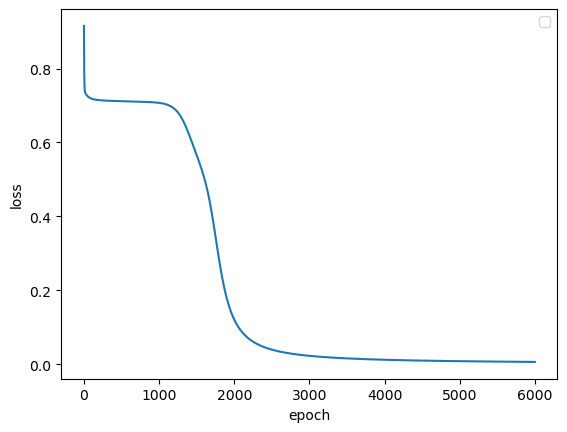

In [14]:
plt.plot(losses)
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()